<a href="https://colab.research.google.com/github/berilldindar/DeepDream/blob/main/DeepDream_KKU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DEEP Dream Projesi**

*Proje Adımları*

Bütün skalalar içinden en küçüğünden başlamalısın


*   Orjinal Görüntünün Yüklenmesi
*   İşlem sayısının belirlenmesi buna oktav diyoruz( oktav küçükten büyüğe doğru belirlenmeli)
*   Orjinal görüntüyü en küçük skalaya göre yeniden boyutlandır
*   Bütün skalalar içinden en küçüğünden başlamalısın


1.  Gradyan yükseliş algoritmasını başlat
2.  Görüntüleri upscale yaparak büyüt
3. Yükselen zamanında kaybolan(loss_detail) detayları yeniden düşün
4. Orjinal görüntünün boyutlarına ulaşınca işlemleri durdur

**NOT:** Yükseltme sırasında kaybolan ayrıntıyı elde etmek için orjinal görüntüyü alır,küçültür, ölçeklendirirve sonucu(yeniden boyutlandırarak orjinal görüntüyle karşılaştırırız.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

base_image_path=keras.utils.get_file("yeni.jpg","https://bm.kku.edu.tr/Content/bm/Slayt/blm.png?w=1200&mode=max&scale=stretch")
result_prefix="kku_dream"


#Aktivasyonu en üst düzeye çıkarmaya çalıştığımız katmanların(layer) adları
# ve en üst düzeye çıkarmaya çalıştığımız son kayıptaki(loss) ağırlık değerleridir.

#Yeni görsel ve efektler elde etmek için bu ayarları değiştirmemiz yeterli olur.

layer_settings={
    "mixed4":4.0,
    "mixed5":3.5,
    "mixed6":2.0,
    "mixed7":5.5,
}

# Buradaki parametrelerle oynamak da yeni efektler elde etmemizi sağlar.
step=0.01
#Gradyan çıkış adımı boyutu (bir skaler alanın yön türevi artımın en çok olduğu yere doğru yönelmiş bir vektör alanını verir)
num_octave=3      #Gradyan yükselmesinin çalıştırılacağı gerekli ölçek sayısı 
octave_scale=1.4  #Ölçekler arasındaki boyut oranı
iterations=20     #Ölçek başına çıkış adımı sayısı
max_loss=15.0     #Maksimum kayıp

442368/439423 [==============================] - 4s 8us/step


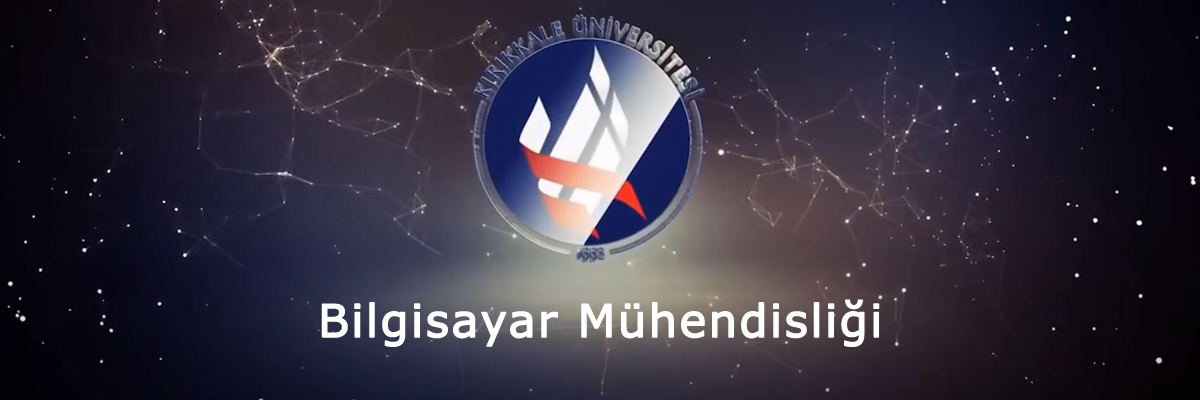

In [ ]:
from IPython.display import Image, display
display(Image(base_image_path))
# Girişte verdiğimiz görüntü

In [ ]:
def preprocess_image(image_path):
  #Resimleri uygun dizilere yüklemek,yeniden boyutlandırmak ve biçimlendirmek için keras util işlevi
  img=keras.preprocessing.image.load_img(image_path)
  img=keras.preprocessing.image.img_to_array(img)
  img=np.expand_dims(img,axis=0) #boyutlandırma(dimension)
  img=inception_v3.preprocess_input(img)
  return img
  #encoding ve decoding işlemi 

def deprocess_image(x):
    # Numpy kütüphanesinin dizisini geçerli bir görüntüye dönüştürmek için util işlevi
    x=x.reshape((x.shape[1],x.shape[2],3))
    # Burada inceptionv3 ön işlemesinin geri alıyoruz 
    x/=2.0
    x+=0.5
    x*=255.0
    #[0,255] piksel değerlerine göre kırpıyoruz ve dönüşümünü sağlıyoruz
    x=np.clip(x,0,255).astype("uint8")
    return x

In [ ]:
# Önceden eğitilmiş imagenet ağırlıklarıyla dolu bir inceptionv3 modeli oluşturuyorum
model=inception_v3.InceptionV3(weights="imagenet",include_top=False)
# her anahtar katmanın(layer yukarıda ağırlıklarını belirlediğimiz) sembolik çıktısını alıyoruz ve isimlendiriyoruz
outputs_dict=dict(
    [
    (layer.name, layer.output)
    for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
#Her hedef katman için de etkinleştirmek için değer döndüren bir özellik çıkarma modeli oluşturuyoruz 
#Burada kayıpları hesaplamaya başlıyoruz özelliklere göre
feature_extractor=keras.Model(inputs=model.inputs,outputs=outputs_dict)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
def compute_loss(input_image):
  features=feature_extractor(input_image)
  #Kayıp fonksiyonu oluşturdum
  loss=tf.zeros(shape=())
  for name in features.keys():
    coeff=layer_settings[name]
    activation=features[name]
    #sınırda olmayan pikselleri dahil ediyorum ve kenarlık oluşumunu engellemeye çalışıyorum
    scaling=tf.reduce_prod(tf.cast(tf.shape(activation),"float32"))
    loss+= coeff*tf.reduce_sum(tf.square(activation[:,2:-2,2:-2,:])) /scaling
  return loss

In [ ]:
@tf.function
def gradient_ascent_step(img,learning_rate): #gradyan çıkış fonksiyonu
#değişken (value) olarak görüntüyü veririz ve öğrenme adımına göre kaç adımda sonuca ulaşacağımızı tahminler.
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss=compute_loss(img)

    grads=tape.gradient(loss,img)

    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)),1e-6)

    img+= learning_rate*grads
    return loss,img

def gradient_ascent_loop(img,iterations,learning_rate,max_loss=None):
    for i in range(iterations):
        loss,img=gradient_ascent_step(img,learning_rate)
        if max_loss is not None and loss>max_loss:
          break
        print("... loss value at step %d: %.2f" %(i,loss))
    return img

Farklı oktavları döngüyle yineleyerek bir eğitim döngüsü oluşturdum

In [ ]:
original_img=preprocess_image(base_image_path)
original_shape=original_img.shape[1:3]

succesive_shapes=[original_shape]
for i in range(1,num_octave):
  shape=tuple([int(dim/(octave_scale**i)) for dim in original_shape])
  succesive_shapes.append(shape)
succesive_shapes=succesive_shapes[::-1]
shrunk_original_img=tf.image.resize(original_img,succesive_shapes[0]) 

img=tf.identity(original_img)
for i,shape in enumerate(succesive_shapes):
  print("Processing octave %d with shape %s" % (i,shape))
  img= tf.image.resize(img,shape)
  img= gradient_ascent_loop(
      img, iterations=iterations, learning_rate=step, max_loss=max_loss
      #bizim için önemli parametreler vardı bunlar görüntünün iterasyonu, öğrenme adımı ve maksimum kayıp
  )
  upscaled_shrunk_original_img=tf.image.resize(shrunk_original_img,shape) # eğittiğimiz görüntüyü orjinal boyutlarına gelene kadar büyütüyoruz
  same_size_original=tf.image.resize(original_img,shape)
  lost_detail=same_size_original-upscaled_shrunk_original_img

  img+=lost_detail
  shrunk_original_img=tf.image.resize(original_img,shape)

keras.preprocessing.image.save_img(result_prefix+".png",deprocess_image(img.numpy())) #png dosyası olarak kaydettim



Processing octave 0 with shape (204, 612)
... loss value at step 0: 1.25
... loss value at step 1: 1.41
... loss value at step 2: 1.80
... loss value at step 3: 2.22
... loss value at step 4: 2.62
... loss value at step 5: 3.03
... loss value at step 6: 3.44
... loss value at step 7: 3.82
... loss value at step 8: 4.18
... loss value at step 9: 4.55
... loss value at step 10: 4.94
... loss value at step 11: 5.28
... loss value at step 12: 5.66
... loss value at step 13: 6.02
... loss value at step 14: 6.39
... loss value at step 15: 6.79
... loss value at step 16: 7.18
... loss value at step 17: 7.48
... loss value at step 18: 7.87
... loss value at step 19: 8.22
Processing octave 1 with shape (285, 857)
... loss value at step 0: 2.49
... loss value at step 1: 3.73
... loss value at step 2: 4.70
... loss value at step 3: 5.55
... loss value at step 4: 6.32
... loss value at step 5: 7.14
... loss value at step 6: 7.87
... loss value at step 7: 8.59
... loss value at step 8: 9.35
... los

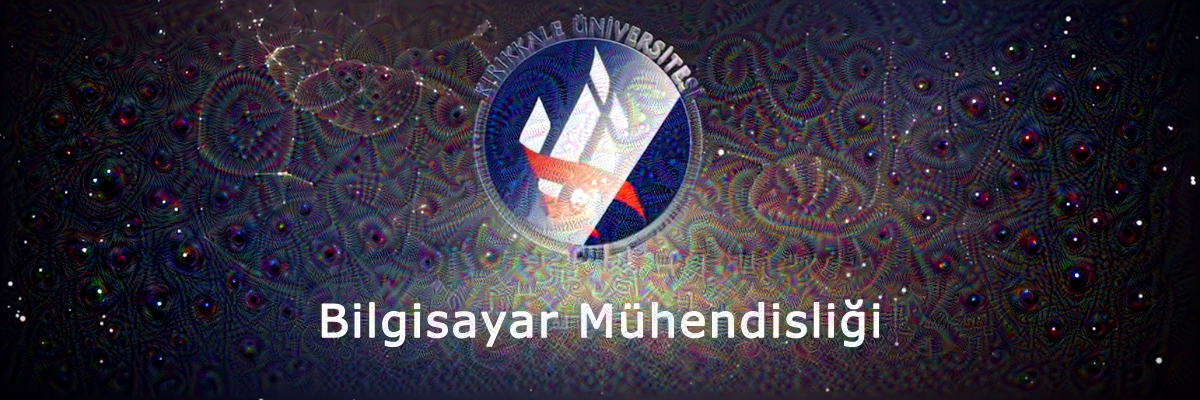

In [ ]:
display(Image(result_prefix + ".png"))